<a href="https://colab.research.google.com/github/zilioalberto/Ciencia_De_Dados/blob/main/Aula06_Complemento_Final%20(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 06 —
**Dupla:** Alberto Zilio • Roni Pereira  
**Projeto:** Mercado imobiliário — Centro de Florianópolis (2022)
**Pergunta de negócio:**  *Qual é o impacto e o peso relativo dos fatores locacionais (vista para o mar, proximidade à Beira Mar Norte) e características do imóvel (tamanho em m² e número de vagas de garagem) no preço de venda de apartamentos no bairro Centro de Florianópolis, e como a vista para o mar influencia a variação do preço por m², com base em anúncios de 2022?*

## 1. Introdução e Pergunta de Negócio




Neste relatório, realizamos uma análise exploratória do dataset **Florianópolis Downtown Real Estate Analysis (FDRSA) — arquivo tb_mercadoimob.csv** (anúncios de 2022, foco no bairro Centro).

**Pergunta de negócio:**
“Qual é o impacto e o peso relativo dos fatores locacionais (vista para o mar, proximidade à Beira Mar Norte) e características do imóvel (tamanho em m² e número de vagas de garagem) no preço de venda de apartamentos no bairro Centro de Florianópolis, e como a vista para o mar influencia a variação do preço por m², com base em anúncios de 2022?”

**Variável-alvo:** preco_m2 (preço por metro quadrado).
As análises a seguir buscam identificar quais variáveis explicativas apresentam maior influência sobre o preco_m2, com ênfase em vista_mar_bin (vista para o mar), proximidade à Beira Mar (distância calculada via lat/lon), area (m²) e num_vagas_garagem

In [34]:
# Se precisar instalar libs no Colab:
!pip install -q pandas seaborn matplotlib statsmodels openpyxl

# ================== IMPORTS E CONFIG ==================
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 120)

# ================== ARQUIVOS ==================
ARQ_LIMPO_XLSX = "/content/dados_atualizados.xlsx"
ARQ_CSV_ORIG   = "/content/tb_mercadoimob.csv"

# ================== CARREGAR DADOS ==================
if os.path.exists(ARQ_LIMPO_XLSX):
    # Excel limpo priorizado, se existir
    df = pd.read_excel(ARQ_LIMPO_XLSX, engine="openpyxl")
else:
    # Cai para CSV bruto
    df = pd.read_csv(ARQ_CSV_ORIG)

# ================== NORMALIZAR NOMES DE COLUNAS ==================
# (acentos -> ascii, minúsculas, _)
df.columns = (
    df.columns
      .astype(str)
      .str.normalize('NFKD').str.encode('ascii', 'ignore').str.decode('ascii')
      .str.lower().str.strip()
      .str.replace(r'[^a-z0-9_]+', '_', regex=True)
)

# ================== GARANTIR COLUNA preco_m2 ==================
if 'preco_m2' not in df.columns:
    candidatos_preco = ['preco', 'valor', 'preco_total', 'valor_total']
    candidatos_area  = ['area', 'area_m2', 'm2', 'metragem', 'area_total']

    col_preco = next((c for c in candidatos_preco if c in df.columns), None)
    col_area  = next((c for c in candidatos_area  if c in df.columns), None)

    if not col_preco or not col_area:
        raise KeyError(
            f"Faltam colunas de preço/área para calcular preco_m2. "
            f"Colunas atuais: {list(df.columns)}"
        )

    preco = pd.to_numeric(df[col_preco], errors='coerce')
    area  = pd.to_numeric(df[col_area],  errors='coerce')

    # evita divisão por zero
    area = area.replace(0, np.nan)
    df['preco_m2'] = preco / area

# ================== VISTA PARA O MAR ==================
# 1) Se houver 'vista_mar' (ou variantes), normaliza para binário;
# 2) Senão, tenta extrair por regex de titulo/descricao.

# Corrige casos de escrita diferente (ex.: vista_Mar) após normalização já feita
if 'vista_mar' not in df.columns and 'vista_mar' in {c.lower(): c for c in df.columns}:
    # Já está normalizado, então este bloco costuma não ser necessário.
    pass

# Se ainda não existe, tenta criar por palavras-chave em titulo/descricao
if 'vista_mar' not in df.columns:
    col_tit  = next((c for c in ['titulo', 'title'] if c in df.columns), None)
    col_desc = next((c for c in ['descricao', 'description'] if c in df.columns), None)

    if col_tit or col_desc:
        pat = r'vista\s*mar|vista\s*para\s*o\s*mar'
        p_tit  = df[col_tit].astype(str).str.contains(pat, case=False, na=False) if col_tit else False
        p_desc = df[col_desc].astype(str).str.contains(pat, case=False, na=False) if col_desc else False
        df['vista_mar'] = (p_tit | p_desc)
    else:
        # Cria coluna vazia se não dá para inferir
        df['vista_mar'] = pd.Series(pd.NA, index=df.index)

# Converter 'vista_mar' para 0/1 (Int64) e rótulos amigáveis
txt = df['vista_mar'].astype(str).str.strip().str.lower()
map_bool = {
    'true': True, 'false': False, '1': True, '0': False,
    'sim': True, 'nao': False, 'não': False, 'yes': True, 'no': False,
    'y': True, 'n': False
}
ser_bool = txt.map(map_bool)  # pode gerar NaN quando não mapeia
df['vista_mar_bin'] = ser_bool.map({True: 1, False: 0}).astype('Int64')

# Completar NaN usando regex (se existir titulo/descricao)
if df['vista_mar_bin'].isna().any():
    pat = r'vista\s*mar|vista\s*para\s*o\s*mar'
    tit_has  = 'titulo' in df.columns
    desc_has = 'descricao' in df.columns
    if tit_has or desc_has:
        tit_mask  = df['titulo'].astype(str).str.contains(pat, case=False, na=False) if tit_has else False
        desc_mask = df['descricao'].astype(str).str.contains(pat, case=False, na=False) if desc_has else False
        mask_na = df['vista_mar_bin'].isna()
        df.loc[mask_na, 'vista_mar_bin'] = (tit_mask | desc_mask).astype('Int64')

# Label para gráficos
df['vista_mar_label'] = df['vista_mar_bin'].map({1: 'Com vista', 0: 'Sem vista'}).astype('category')

# ================== SAÍDA RÁPIDA ==================
print("Dimensão do df:", df.shape)
display(df.head(3))


Dimensão do df: (4395, 20)


,id,titulo,descricao,area,data_anuncio,num_andares,num_vagas_garagem,num_suites,num_banheiros,num_quartos,valor,iptu,taxa_condominial,tipo_imovel,tipo_negocio,cep,preco_m2,vista_mar,vista_mar_bin,vista_mar_label
0,7784,Florianópolis - Apartamento Padrão - Trindade,"Excelente apartamento no bairro Trindade de 3 dormitórios (sendo 1 suíte), sala de estar, sacada com churrasqueira, ...",91,2020-04-22 14:40:19,0,2,1,1,3,1160361,0,0,Apartamento,Venda,88010400,12751.219780,False,0,Sem vista
1,11420,Apartamento para venda possui 46 metros quadrados com 1 quarto em Centro - Florianópolis - SC,O apartamento está localizado no bairro Centro tem 46 metros quadrados com 1 quarto sendo 1 suite e 2 banheiros<br>P...,46,2022-03-19 15:09:57,7,2,1,2,1,460000,600,700,Apartamento,Venda,88020620,10000.000000,False,0,Sem vista
2,11432,"Apartamento com 3 dormitórios à venda, 75 m² por R$ 310.000,00 - Centro - Florianópolis/SC",Ótimo Apartamento com 03 quartos à Venda no Centro de Florianópolis - SC por apenas 310 mil reais<br><br>Imóvel tem ...,75,2022-02-09 03:51:58,0,2,1,2,3,310000,0,600,Apartamento,Venda,88020302,4133.333333,False,0,Sem vista


## 2. Análise Univariada: Entendendo as Variáveis Principais

Primeiro, analisamos a distribuição das variáveis mais importantes individualmente para entender o perfil do conjunto. Começamos pela variável-alvo preco_m2 (preço por metro quadrado), pois todas as demais análises e o modelo final vão explicar variações nessa métrica

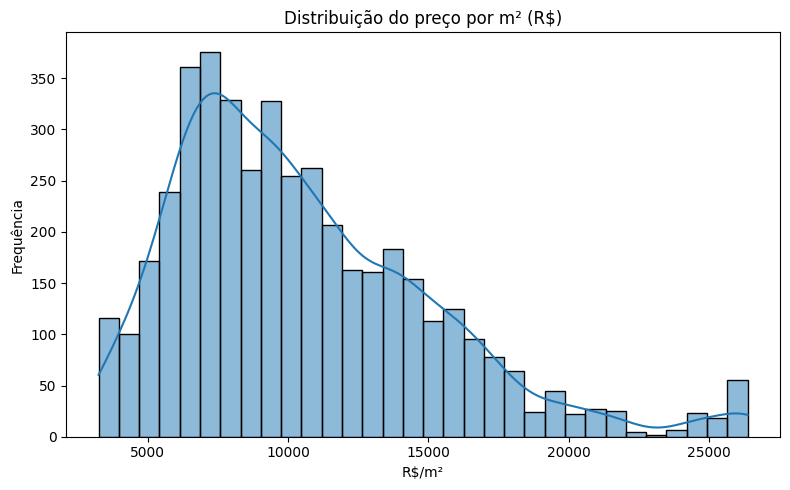

N=4394 | min=0.00 | mediana=9523.81 | p90=16628.42 | max=11818181.82


In [35]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

# Série limpa da variável-alvo
s = pd.to_numeric(df['preco_m2'], errors='coerce').dropna()

# Aparar extremos para visual (winsorização 1%–99% sem alterar o df original)
if len(s) >= 50:
    p1, p99 = s.quantile([0.01, 0.99])
    s_plot = s.clip(p1, p99)
else:
    s_plot = s

plt.figure(figsize=(8,5))
sns.histplot(s_plot, bins='auto', kde=True)
plt.title('Distribuição do preço por m² (R$)')
plt.xlabel('R$/m²')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

print(f"N={len(s)} | min={s.min():.2f} | mediana={s.median():.2f} | p90={s.quantile(0.90):.2f} | max={s.max():.2f}")


**Insight 1:**
O histograma de preco_m2 é assimétrico à direita, com cauda longa e outliers nas faixas mais altas. Isso é importante porque indica que médias simples podem ser puxadas para cima, tornando a mediana/IQR (ou transformações como log) escolhas mais robustas para resumo e modelagem. Também sugere aplicar capagem/winsorização na etapa de EDA e considerar modelos robustos/quantílicos quando formos estimar o impacto de vista, proximidade à Beira-Mar e características do imóvel sobre o preco_m2.

## 3. Análise Bivariada: Buscando Relações com a Variável-Alvo

Agora, começamos a cruzar variáveis para encontrar relações que ajudem a responder nossa pergunta.
Nossa primeira hipótese é que vista_mar_bin (1=Com vista; 0=Sem vista) influencia preco_m2.

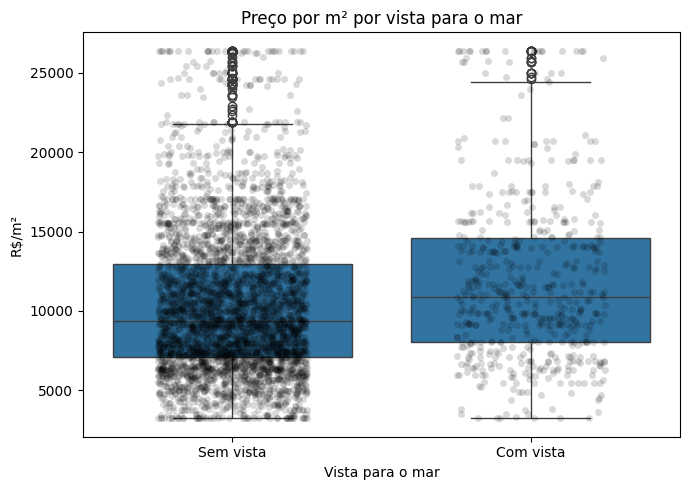

,n,mediana,media
vista,,,
Com vista,550,10876.325088,12064.988729
Sem vista,3844,9379.844961,13392.936858


Prêmio de mediana (com vista vs. sem vista): R$ 1,496/m²  (16.0%).


In [36]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

assert 'preco_m2' in df.columns, "Falta a coluna preco_m2."
assert 'vista_mar_bin' in df.columns, "Falta a coluna vista_mar_bin. Volte à etapa de normalização."

# Base e rótulos legíveis
tmp = df[['preco_m2','vista_mar_bin']].copy().dropna()
tmp['vista'] = tmp['vista_mar_bin'].map({1:'Com vista', 0:'Sem vista'})

# Aparar extremos para visual (não altera os cálculos de mediana/mean)
tmp_plot = tmp.copy()
if len(tmp_plot) >= 80:
    lo, hi = tmp_plot['preco_m2'].quantile([0.01, 0.99])
    tmp_plot['preco_m2'] = tmp_plot['preco_m2'].clip(lo, hi)

plt.figure(figsize=(7,5))
sns.boxplot(data=tmp_plot, x='vista', y='preco_m2')
sns.stripplot(data=tmp_plot, x='vista', y='preco_m2', color='k', alpha=.15, jitter=.25)
plt.title('Preço por m² por vista para o mar')
plt.xlabel('Vista para o mar'); plt.ylabel('R$/m²')
plt.tight_layout(); plt.show()

# Resumo numérico (mediana, média e contagem por grupo)
res = (tmp.groupby('vista')['preco_m2']
          .agg(n='count', mediana='median', media='mean')
          .sort_index())
display(res)

# Diferença absoluta e percentual entre as medianas (Com vista - Sem vista)
if {'Com vista','Sem vista'}.issubset(res.index):
    med_vista = res.loc['Com vista','mediana']
    med_sem   = res.loc['Sem vista','mediana']
    diff_abs  = med_vista - med_sem
    diff_pct  = (diff_abs/med_sem*100.0) if med_sem > 0 else np.nan
    print(f"Prêmio de mediana (com vista vs. sem vista): R$ {diff_abs:,.0f}/m²  ({diff_pct:.1f}%).")


**Insight 2:**
Como esperado, o boxplot indica que apartamentos “com vista” tendem a apresentar mediana de preco_m2 mais alta do que os “sem vista” (veja o prêmio de mediana calculado logo abaixo do gráfico). Isso sugere que vista_mar_bin é um forte candidato para o nosso modelo explicativo de preco_m2. Na etapa seguinte, estimaremos esse efeito controlando por area, num_vagas_garagem e proximidade à Beira-Mar, para obter o peso relativo da vista de forma mais precisa.

## 4. Análise Multivariada: Aprofundando nos Padrões




Para aprofundar, usamos um heatmap para ter uma visão geral de todas as correlações e um scatter plot com hue para investigar subgrupos (apartamentos com vs sem vista), além de variar o tamanho pelo nº de vagas.

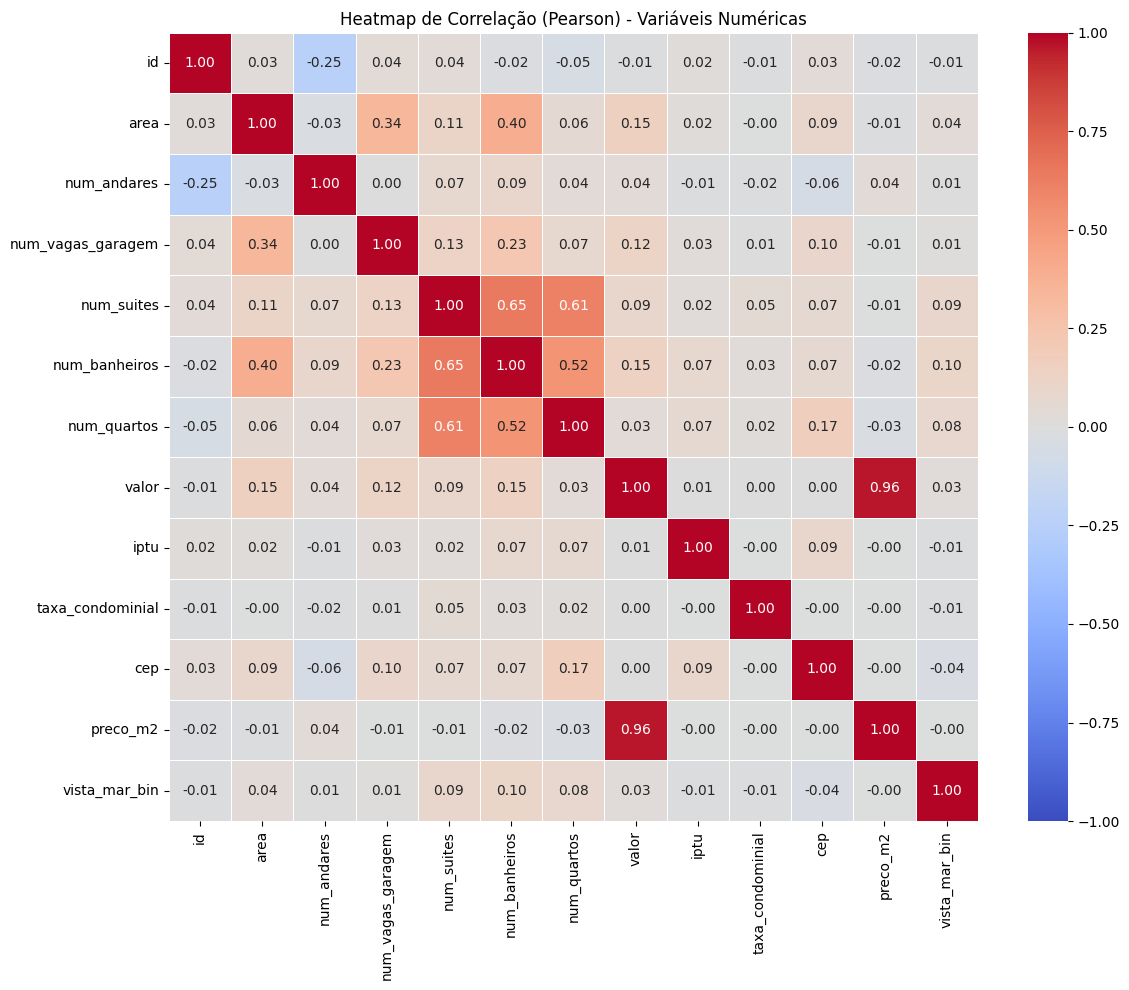

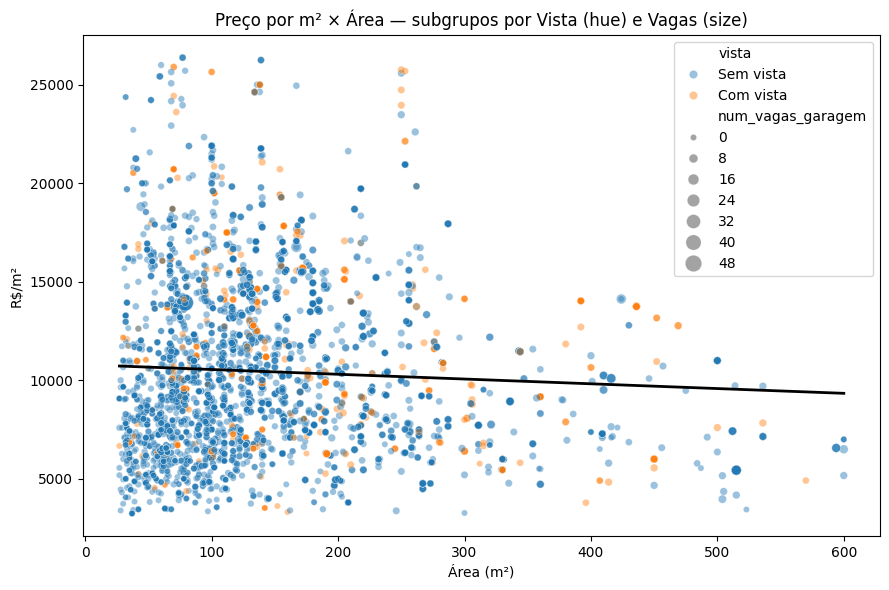

In [37]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

# ----- HEATMAP (Pearson) -----
df_num = df.select_dtypes(include=[np.number]).copy()
if 'vista_mar_bin' in df.columns and 'vista_mar_bin' not in df_num.columns:
    df_num['vista_mar_bin'] = pd.to_numeric(df['vista_mar_bin'], errors='coerce')

# remover colunas totalmente nulas e quase-constantes
df_num = df_num.dropna(axis=1, how='all')
const_cols = [c for c in df_num.columns if df_num[c].nunique(dropna=True) < 2]
df_num = df_num.drop(columns=const_cols, errors='ignore')

corr = df_num.corr(method='pearson', min_periods=1)

plt.figure(figsize=(max(12, 0.7 * df_num.shape[1]), max(10, 0.6 * df_num.shape[1])))
sns.heatmap(corr, vmin=-1, vmax=1, cmap='coolwarm',
            annot=(df_num.shape[1] <= 16), fmt='.2f', linewidths=.5)
plt.title('Heatmap de Correlação (Pearson) - Variáveis Numéricas')
plt.tight_layout()
plt.show()

# ----- SCATTER: preco_m2 × area, hue=vista, size=vagas -----
base_cols = ['preco_m2','area','num_vagas_garagem']
assert all(c in df.columns for c in base_cols), "Faltam colunas para o scatter."

plot_df = df[base_cols + (['vista_mar_bin'] if 'vista_mar_bin' in df.columns else [])].copy().dropna()
# rótulo legível para vista
if 'vista_mar_bin' in plot_df.columns:
    plot_df['vista'] = plot_df['vista_mar_bin'].map({1:'Com vista', 0:'Sem vista'})
else:
    plot_df['vista'] = 'Sem info'

# aparar extremos para visual
if len(plot_df) >= 80:
    x_lo, x_hi = plot_df['area'].quantile([0.01, 0.99])
    y_lo, y_hi = plot_df['preco_m2'].quantile([0.01, 0.99])
    plot_df = plot_df[plot_df['area'].between(x_lo, x_hi) & plot_df['preco_m2'].between(y_lo, y_hi)]

plt.figure(figsize=(9,6))
sns.scatterplot(data=plot_df, x='area', y='preco_m2',
                hue='vista', size='num_vagas_garagem',
                sizes=(20, 140), alpha=0.45)
sns.regplot(data=plot_df, x='area', y='preco_m2', scatter=False, color='black', ci=None, line_kws={'lw':2})
plt.title('Preço por m² × Área — subgrupos por Vista (hue) e Vagas (size)')
plt.xlabel('Área (m²)'); plt.ylabel('R$/m²')
plt.tight_layout()
plt.show()


**Insight 3:**
O heatmap revela uma correlação alta entre num_banheiros e num_suites (e também correlações relevantes com num_quartos). Embora não esteja diretamente ligada à variável-alvo preco_m2, isso indica multicolinearidade dentro do “programa interno” do imóvel. Na prática, devemos evitar levar todas essas variáveis juntas para o modelo (ou usar apenas uma representativa), sob risco de inflar variâncias e distorcer os pesos relativos. O scatter ainda mostra que, mantendo a área como eixo principal, subgrupos por “vista” e nº de vagas podem apresentar níveis diferentes de R$/m², reforçando que efeitos locacionais e de vagas devem ser medidos com controle (área) e possivelmente com interações.

### 5. Conclusão e Próximos Passos para a Modelagem

**Resumo dos Principais Achados:**

**Achado 1:** Existe um bloco forte de correlações entre num_quartos, num_banheiros e num_suites, indicando multicolinearidade (variáveis do “programa interno” sobem juntas). Para modelagem, evitar levar todas ao mesmo tempo.

**Achado 2:** area × valor apresenta tendência positiva (scatter), mas no Pearson global a força é diluída por heterocedasticidade e outliers. Para a variável-alvo preco_m2, o efeito da área pode ser não linear (ex.: m² de unidades muito grandes tende a valer menos).

**Achado 3:** No agregado, vista_mar_bin não mostra correlação alta com preco_m2; o prêmio de vista parece segmentado (depende de faixa de área/andar/localização). Isso reforça a necessidade de controle locacional e interações.

**Recomendação para a Modelagem:**
Com base nesta análise, as variáveis mais promissoras para incluir em um modelo preditivo para preco_m2 são:

vista_mar_bin — (locacional) apesar de correlação global baixa, há evidência visual de prêmio em subgrupos; medir seu efeito condicional fornecerá o peso relativo da vista.

dist_beiramar_km (ou dist_beiramar_m, se disponível) — (locacional) deve capturar a proximidade à Beira Mar Norte; esperamos inclinação negativa (mais perto → R$/m² maior).

area (preferencialmente em faixas ou com transformação log) — (característica) importante para controlar efeitos de escala no preco_m2 e permitir interações com vista.

**Observação:** incluir também num_vagas_garagem como variável de apoio, dado seu papel de diferenciação no Centro.
Boas práticas: winsorizar preco_m2 (P1–P99) ou usar log(preco_m2); testar interações (vista_mar_bin × faixa_de_area e/ou vista_mar_bin × dist_beiramar); escolher uma variável representativa do “programa interno” (ex.: num_quartos) para evitar multicolinearidade; avaliar MAE/MAPE e VIF; usar validação cruzada.